In [1]:
import pandas as pd
import numpy as np
import re, random
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow_hub as hub
embed = hub.load("../../model/")

In [3]:
data = pd.read_csv("../../data/english_dataset/english_dataset.tsv",sep="\t").sample(frac=1)
data.head()

,text_id,text,task_1,task_2,task_3
4306,hasoc_en_4307,@inaik7 @Trendulkar @ICC It's doesn't matter t...,HOF,HATE,TIN
1279,hasoc_en_1280,So Marco Rubio thinks I’m a #traitor because I...,HOF,PRFN,TIN
1743,hasoc_en_1744,@bbc5live @JohnnyMercerUK @Emmabarnett Imagine...,NOT,NONE,NONE
5572,hasoc_en_5573,"@davidfrum @gtconway3d It is not a secret, all...",HOF,HATE,TIN
3498,hasoc_en_3499,#ShameOnICC wondering the number of gaalis ICC...,NOT,NONE,NONE


In [4]:
test_data = pd.read_csv("../../data/english_dataset/hasoc2019_en_test-2919.tsv", sep="\t").sample(frac=1)
test_data.head()

,text_id,text,task_1,task_2,task_3
818,hasoc_en_336,Boom Boom Afridi . . . #worldcup #ipl #cri...,NOT,NONE,NONE
53,hasoc_en_38,Yeah this kinda Taqiyya is done to convince mo...,HOF,PRFN,TIN
60,hasoc_en_964,The simple math that should keep Republicans u...,NOT,NONE,NONE
640,hasoc_en_660,Scandal-plagued Border Patrol would be in char...,NOT,NONE,NONE
623,hasoc_en_201,To kick off his first visit to Scotland as Pri...,NOT,NONE,NONE


In [11]:
create_label({"NOT":0, "HOF":1}, data['task_1'])

4306    1
1279    1
1743    0
5572    1
3498    0
       ..
3592    0
4995    1
1540    0
187     0
880     0
Name: task_1, Length: 5852, dtype: int64

In [6]:
def create_label(labels, data):
    return data.map(labels, na_action='ignore')

In [7]:
def create_model(n_class):
    print("CLASSES:", n_class)
    model = Sequential()
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_class, activation='softmax'))
    return model

In [13]:
def make_train(model, X_train, X_test, y_train, y_test, X_val, y_val, target, epochs=10, batch_size=32,):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=False)
#     results = model.evaluate(X_test, y_test)
#     print("test loss, test acc:", results)
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print("==== CLASSIFICATION REPORT ========= \n", classification_report(y_test, y_pred, target_names=target))
    print("==== CONFUSION MATRIX ==== \n", confusion_matrix(y_test, y_pred))
    return history.history, epochs

In [14]:
# label_task1, label_task2, label_task3 = {'NOT': 0, 'HOF': 1}, {'HATE':0, 'OFFN':1, 'PRFN':2}, {'TIN':0, 'UNT':1}
label = [{'NOT': 0, 'HOF': 1}, {'HATE':0, 'OFFN':1, 'PRFN':2, 'NONE':3}, {'TIN':0, 'UNT':1, 'NONE':2}]

CLASSES: 2
==== CLASSIFICATION REPORT ========= 
               precision    recall  f1-score   support

         NOT       0.82      0.79      0.81       865
         HOF       0.44      0.49      0.46       288

    accuracy                           0.71      1153
   macro avg       0.63      0.64      0.63      1153
weighted avg       0.73      0.71      0.72      1153

==== CONFUSION MATRIX ==== 
 [[684 181]
 [148 140]]


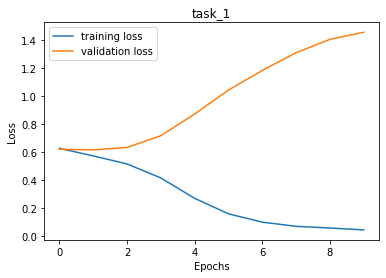

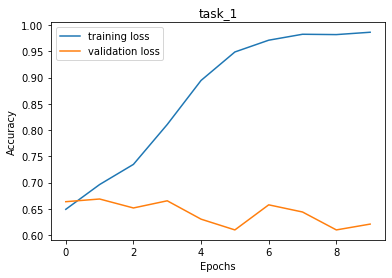

CLASSES: 4
==== CLASSIFICATION REPORT ========= 
               precision    recall  f1-score   support

        HATE       0.22      0.32      0.26       124
        OFFN       0.29      0.07      0.11        71
        PRFN       0.45      0.38      0.41        93
        NONE       0.82      0.83      0.82       865

    accuracy                           0.69      1153
   macro avg       0.45      0.40      0.40      1153
weighted avg       0.69      0.69      0.69      1153

==== CONFUSION MATRIX ==== 
 [[ 40   3  11  70]
 [ 16   5   8  42]
 [ 10   1  35  47]
 [118   8  23 716]]


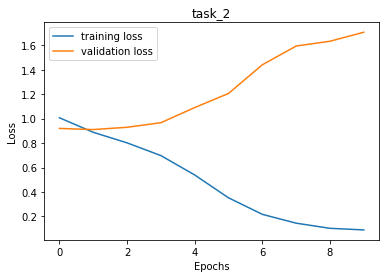

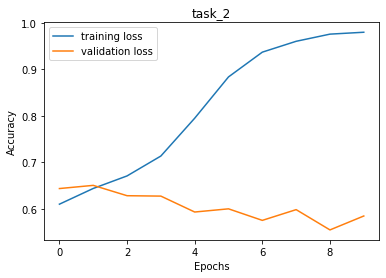

CLASSES: 3
==== CLASSIFICATION REPORT ========= 
               precision    recall  f1-score   support

         TIN       0.33      0.46      0.39       245
         UNT       0.18      0.07      0.10        43
        NONE       0.82      0.76      0.79       865

    accuracy                           0.67      1153
   macro avg       0.44      0.43      0.43      1153
weighted avg       0.69      0.67      0.68      1153

==== CONFUSION MATRIX ==== 
 [[112   9 124]
 [ 22   3  18]
 [201   5 659]]


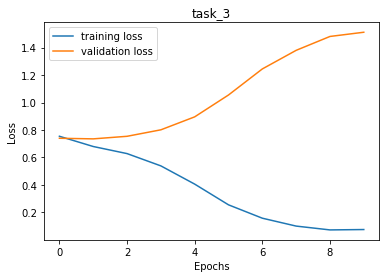

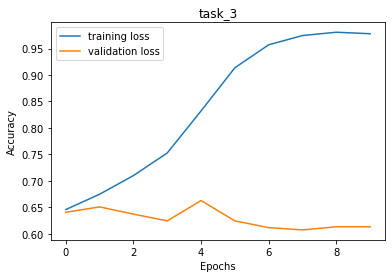

In [16]:
for i in range(1,4):
    col = "task_"+str(i)
    y = create_label(label[i-1], data[col])
    x = data['text']
    
    y_test, X_test = create_label(label[i-1], test_data[col]), test_data['text']
    
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.20, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
    
    X_train_embed = embed(X_train)
    X_test_embed = embed(X_test)
    X_val_embed = embed(X_val)
    
    model = create_model(n_class = len(label[i-1]))
    history, epochs = make_train(model, X_train_embed, X_test_embed, y_train, y_test, X_val_embed, y_val, list(label[i-1].keys()))
    p_y = np.arange(epochs)
    plt.plot(p_y, history['loss'])
    plt.plot(p_y, history['val_loss'])
    plt.legend(['training loss','validation loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(col)
    plt.show()
    
    plt.plot(p_y, history['accuracy'])
    plt.plot(p_y, history['val_accuracy'])
    plt.legend(['training loss','validation loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(col)
    plt.show()